<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ContrastAndColor/GMM_OT_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Transport between Gaussian Mixture Models - Simple experiments

This notebook presents simple experiments using a transportation distance between GMM defined by restricting the set of possible coupling measures to Gaussian mixtures. In the following, we denote by $GMM_{d}(\infty)$ the set of probability distributions which can be written as finite Gaussian mixture models on $\mathbb{R}^d$.

Let $\mu_0$ and $\mu_1$ be two Gaussian mixtures on $\mathbb{R}^d$, we define 
 $$GW_2^2(\mu_0,\mu_1) := \inf_{\gamma \in \Pi(\mu_0,\mu_1) \cap GMM_{2d}(\infty)} \int_{\mathbb{R}^d\times\mathbb{R}^d} \|y_0-y_1\|^2d\gamma(y_0,y_1).$$
The problem is well defined since $\Pi(\mu_0,\mu_1) \cap GMM_{2d}(\infty)$ contains at least the product measure $\mu_0 \otimes \mu_1$.
We can show that $GW_2$ defines a distance, and this distance is obvisouly larger than the Wasserstein distance since it has the same definition with a smaller set of constraints. 

Moreover, if $\mu_0 =\sum_{k=1}^{K_0} \pi_0^k \mu_0^k$ and $\mu_1= \sum_{k=1}^{K_1} \pi_1^k \mu_1^k$, it can be shown that
  $$
 GW_2^2(\mu_0,\mu_1) =  \min_{w \in \Pi(\pi_0,\pi_1)} \sum_{k,l}w_{kl} W_2^2(\mu_0^k,\mu_1^l), $$
where $\Pi(\pi_0,\pi_1)$ is the subset of the discrete probability distributions with marginals $\pi_0$ and $\pi_1$, *i.e.*

$$\Pi(\pi_0,\pi_1) = \{w \in \mathcal{M}_{K_0,K_1}(\mathbb{R}^+);\;\forall k,\sum_j w_{kj} = \pi_0^k \text{ and }\forall j,\;\sum_k w_{kj} = \pi_1^j\;\}.$$

See the following references for more information:

[Delon, Desolneux, *A Wasserstein-type distance in the space of Gaussian Mixture Models*, 2019.](https://hal.archives-ouvertes.fr/hal-02178204)

[Chen, Georgiou, Tannenbaum, *Optimal transport for Gaussian mixture models*, 23rd International Symposium on Mathematical Theory of Networks and Systems, 2018](http://mtns2018.ust.hk/media/files/0122.pdf)




**Authors:**
* [Julie Delon](https://github.com/judelo)

## Importing packages

Below is a list of packages needed and a brief explanation of its use in this notebook:

- `numpy` (library used for working with arrays)
- `matplotlib` (library used for working with images)
-  `scipy.linalg` (library used linear algebra functions)
- `scipy.stats` (library used for probability density functions)
- `ipywidgets` (library used for interactive widgets)
-  `ot` and `ot.plot` (Optimal Transport library https://github.com/rflamary/POT)

In order to use the Optimal Transport library we must first install it using PIP. 

In [3]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 4.4 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
import scipy.stats as sps
%matplotlib inline

import ot                 
import ot.plot

from ipywidgets import interact, interactive, fixed, interact_manual

To import the solutions, execute the following cell.

In [5]:
#@title
from scipy.optimize import linprog

#################
### author : Julie Delon
#################

###############################
#### display GMM
###############################


def display_gmm(gmm,n=50,ax=0,bx=1,ay=0,by=1,cmap='viridis',axis=None):
    
    if axis is None:
        axis = plt.gca()
        
    [K,pi,mu,S] = gmm
    
    x = np.linspace(ax, bx,num=n)
    y = np.linspace(ay, by,num=n)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = densite_theorique2d(mu,S,pi,XX)
    Z = Z.reshape(X.shape)
    plt.axis('equal')
    return axis.contour(X, Y, Z,8,cmap=cmap)    

###############################
#### compute GMM densities
###############################

def densite_theorique(mu,var,alpha,x):
    # compute the 1D GMM density with parameters (mu,var) and weights alpha  at x 
    K=mu.shape[0]
    y=0
    #y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j,:],scale=np.sqrt(var[j,:,:]))
    return y.reshape(x.shape)

def densite_theorique2d(mu,Sigma,alpha,x):
    # compute the 2D GMM density with parameters (mu, Sigma) and weights alpha at x
    K = mu.shape[0]
    alpha = alpha.reshape(1,K)
    y=0
    for j in range(K):
        y+=alpha[0,j]*sps.multivariate_normal.pdf(x,mean=mu[j,:],cov=Sigma[j,:,:])
    return y

###############################
### Optimal Transport between Gaussians (quadratic Wasserstein)
###############################

def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    # Compute the OT map (evaluated at x) between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1 
    # m0 and m1 must be 2D arrays of size 1xd
    # Sigma0 and Sigma1 must be 2D arrays of size dxd
    # x can be a matrix of size n x d,
    # each column of x is a vector to which the function is applied
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx

def GaussianBarycenterW2(mu,Sigma,alpha,N):
    # Compute the W2 barycenter between several Gaussians
    # mu has size Kxd, with K the number of Gaussians and d the space dimension
    # Sigma has size Kxdxd
    K        = mu.shape[0]  # number of Gaussians
    d        = mu.shape[1]  # size of the space
    Sigman   = np.eye(d,d)
    mun      = np.zeros((1,d))
    cost = 0
    
    for n in range(N):
        Sigmandemi       = spl.sqrtm(Sigman)
        T = np.zeros((d,d))
        for j in range(K):
            T+= alpha[j]*spl.sqrtm(Sigmandemi@Sigma[j,:,:]@Sigmandemi)
        Sigman  = T
    
    for j in range(K):
        mun+= alpha[j]*mu[j,:]
    
    for j in range(K):
        cost+= alpha[j]*GaussianW2(mu[j,:],mun,Sigma[j,:,:],Sigman)

    return mun,Sigman,cost       # return the Gaussian Barycenter (mun,Sigman) and the total cost


###############################
###### GW2 between GMM
###############################


def GW2(pi0,pi1,mu0,mu1,S0,S1):
    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    M  = np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    # Then we compute the OT distance or OT map thanks to the OT library
    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan
    distGW2   = np.sum(wstar*M)
    return wstar,distGW2

def GW2cost(mu0,mu1,S0,S1):       # return the distance matrix M of size K0 x K1
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    M = np.zeros((K0,K1))
    # we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            M[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    return M

def GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x):      
    # return the GW2 maps between two GMM on the 1D grid x  
    n,K0,K1    = x.shape[0],mu0.shape[0],mu1.shape[0]
    T          = np.zeros((K0,K1,n))     # each Tkl = T[k,l,:] is of dimension n and correspond to the W2-map between component k of mu0 and component l of mu1
    tmpmean    = np.zeros(n)
    weightmean = np.zeros(n)
    Tmean      = np.zeros((n,n))     # averaged map on a grid 
    Tmap       = np.zeros((n,n))     # multivalued map on a grid
    
    for k in range(K0):
        for l in range(K1):
            if wstar[k,l]!=0:
                T[k,l,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,],S1[l],x).reshape(n,)
                for i in range(n):
                    Ti             = int(max(min(T[k,l,i],1),0)*99)
                    Tmap[i,Ti]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))
                    tmpmean[i]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))/densite_theorique(mu0,S0,pi0,x[i])*T[k,l,i]
                    weightmean[i] += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=np.sqrt(S0[k]))

    tmpmean = np.uint(np.maximum(np.minimum(tmpmean,1),0)*99)
    for i in range(n):
        Tmean[i,tmpmean[i]] = weightmean[i]
    
    return Tmap,Tmean


#####################################################
##### Multimarginal problem
#####################################################


def create_cost_matrix_from_gmm(gmm,alpha,N=10):
    """
    create the cost matrix for the multimarginal problem between all GMM
    create the barycenters (mun,Sn) betweenn all Gaussian components 
    """
    
    nMarginal       = len(alpha)               # number of marginals
    d               = gmm[0][2].shape[1]       # space dimension
    tup = ();
    for k in range(nMarginal):
        K  = gmm[k][0]
        tup+=(K,)        
    C               = np.zeros(tup)
    mun             = np.zeros(tup+(d,))
    Sn             = np.zeros(tup+(d,d))
        
    it = np.nditer(C,["multi_index"])
    while not it.finished:
        tup = it.multi_index        
        mu = np.zeros((nMarginal,d))
        Sigma = np.zeros((nMarginal,d,d))
        
        for k in range(nMarginal):
            mu[k,:]      = gmm[k][2][tup[k]]
            Sigma[k,:,:] = gmm[k][3][tup[k]]
            
        mu    = np.array(mu)    
        Sigma = np.array(Sigma)    
        [mun[tup],Sn[tup],cost] = GaussianBarycenterW2(mu,Sigma,alpha,N)
        
        C[tup] = cost
        
        it.iternext()
    
    return C,mun,Sn  

def solveMMOT(pi, costMatrix, epsilon = 1e-10):
    """ Author : Alexandre Saint-Dizier
    
    Solveur of the MultiMargnal OT problem, using linprog

    Input :
     - pi : list(array) -> weights of the different distributions
     - C : array(d1,...dp) -> cost matrix
     - epsilon : smallest value considered to be positive

    Output :
     - gamma : list of combinaison with positive weight
     - gammaWeights : corresponding weights
    """

    nMarginal = len(pi);
    nPoints = costMatrix.shape;

    nConstraints = 0; nParameters = 1;
    for ni in nPoints:
        nConstraints += ni; nParameters *= ni

    index = 0;
    A = np.zeros((nConstraints, nParameters)); b = np.zeros(nConstraints)
    for i in range(nMarginal):
        ni = nPoints[i];
        b[index:index+ni] = pi[i];
        for k in range(ni):
            Ap = np.zeros(costMatrix.shape);
            tup = ();
            for j in range(nMarginal):
                if j==i:
                    tup+= (k,)
                else:
                    tup+=(slice(0,nPoints[j]),)
            Ap[tup] = 1;
            A[index+k,:]=Ap.flatten();
        index += ni
    A = A.tolist(); b = b.tolist();
    C = costMatrix.flatten().tolist()

    res = linprog(C, A_eq=A, b_eq =b) #Solve inf <C,X> with constraints AX=b
    gammaWeights = res.x;
    gammaWeights = gammaWeights.reshape(costMatrix.shape)
   
    return gammaWeights


####################################################
#### for color transfer or color barycenters   #####
#### guided_filter is used for post-processing #####
####################################################


def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window
    # u is a 2d image
    # r is the radius for the filter
    
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
    
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

def guided_filter(u,guide,r,eps):
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide
    
    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide
    
    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C
    
    q = mean_alph * guide + mean_beta
    return q

## Optimal Transport between Gaussian Mixture Models in 1D

We start with simple 1D experiments, with 
$$\mu_0 = 0.3 \mathcal{N}(0.2,0.0009)+ 0.7\mathcal{N}(0.4,0.0016),$$
$$\mu_1 = 0.6 \mathcal{N}(0.6,0.0036)+ 0.4\mathcal{N}(0.8,0.0049).$$

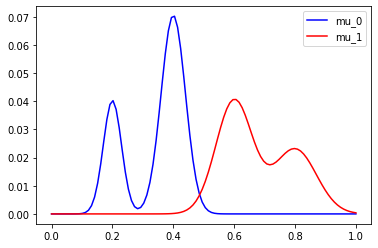

In [6]:
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
#S0  = np.array([[[.03]],[[.04]]])
S0  = np.array([[[.0009]],[[.0016]]])

K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.6,.4])    
mu1 = np.array([[.6,.8]]).T   
#S1 = np.array([[[.06]],[[.07]]])
S1 = np.array([[[.0036]],[[.0049]]])
K1 = pi1.shape[0]

# GMM densities
n    = 100
x    = np.linspace(0,1,num=n)
gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

## Transportation maps 

We can compute the traditionnal Wasserstein map between $\mu_0$ and $\mu_1$ thanks to the function `ot.emd` of the POT library.

### For $W_2$

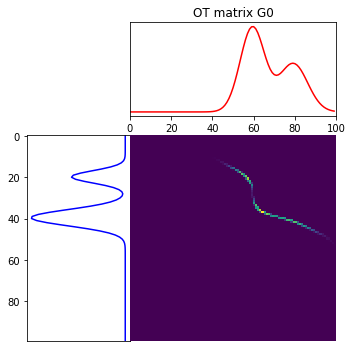

In [7]:
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0')

### For $GW_2$ 

Now we compute the $GW_2$-map. We start by computing the $K0\times K1$ cost matrix between all the Gaussian components of the two mixtures.

In [8]:
wstar,dist = GW2(pi0,pi1,mu0,mu1,S0,S1)
wstar

array([[0.3, 0. ],
       [0.3, 0.4]])

An optimal transport plan between $\mu_0$ and $\mu_1$ for $GW_2$ is given by
$$  \gamma (x,y) = \sum_{k,l} w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x)
\delta_{y=T_{k,l}(x)},$$
where $T_{k,l}$ is the $W_2$-optimal map between $\mu_0^k$ and $\mu_1^l$ and $w_{k,l}^\ast$ is a solution of the linear program $\inf_{w \in \Pi(\pi_0,\pi_1)} \sum_{k,l}w_{kl} W_2^2(\mu_0^k,\mu_1^l).$

Moreover, if $(X,Y)$ is distributed according to the law $\gamma$, then 
$$ T_{mean}(x) := \mathbb{E}_\gamma (Y | X=x) = \frac{\sum_{k,l}
w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x) T_{k,l}(x)}{\sum_{k} \pi^k_{0} g_{m_0^k,\Sigma_0^k}(x)} .$$

In the following, we compute and display these two maps on a regular grid.

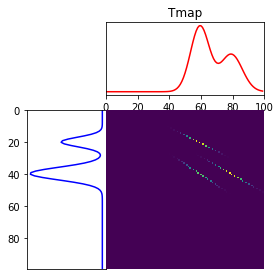

In [9]:
n    = 100
x    = np.linspace(0,1,num=n).reshape(n,1)

Tmap,Tmean = GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x)
plt.figure(3, figsize=(4, 4))
ot.plot.plot1D_mat(gmm0, gmm1, Tmap*10, 'Tmap')

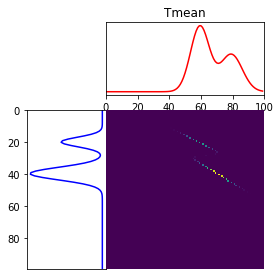

In [10]:
plt.figure(3, figsize=(4, 4))
ot.plot.plot1D_mat(gmm0, gmm1, Tmean, 'Tmean')

## Interpolation 

### Interpolation for $GW_2$

We now compute the interpolation between the two distributions for $GW_2$.

In [11]:
def barygmmot(t):
# Barycenters for GW2
    pit = wstar.reshape(K0*K1,1)
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

interact(barygmmot,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot(t)>

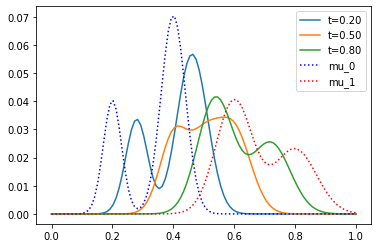

In [12]:
pit = wstar.reshape(K0*K1,1)
for t in [0.2,0.5,.8]:
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt,label='t=%.2f' %t)
    
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend();

### Interpolation for $W_2$

We now compute the interpolation between the two distributions for $W_2$, thanks to the function `ot.barycenter`of the POT library.

In [13]:
# Barycenters for OT
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
A = np.vstack((gmm0, gmm1)).T

def baryot(t):
    weights = np.array([1 - t, t])
    reg = 5*1e-4
    ott = ot.barycenter(A, M, reg, weights)
    plt.plot(x,ott)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

interact(baryot,t=(0.0,1.0,0.001))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.001), Output()), _dom_classes=('…

<function __main__.baryot(t)>

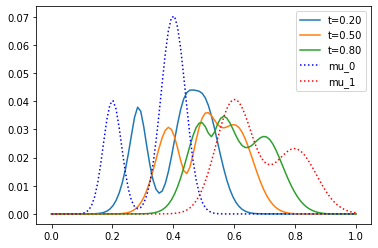

In [14]:
A = np.vstack((gmm0, gmm1)).T
for t in [0.2,0.5,0.8]:
    weights = np.array([1 - t, t])
    reg = 1e-3
    ott = ot.barycenter(A, M, reg, weights)
    plt.plot(x,ott,label='t=%.2f' %t)
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend()
plt.show()

## Optimal Transport between Gaussian Mixture Models in 2D

In the second part of this notebook, we illustrate the use of the distance $GW_2$ for two dimensional Gaussian mixtures. We use the following simple mixtures:
$$\mu_0 = 0.5 \mathcal{N}\left(
  \begin{pmatrix}
    0.3\\0.3
  \end{pmatrix}
,0.01 I_2\right)+ 0.5 \mathcal{N}\left(
  \begin{pmatrix}
    0.7\\0.4
  \end{pmatrix}
,0.01 I_2\right),$$
and
$$\mu_1 = 0.45 \mathcal{N}\left(
  \begin{pmatrix}
    0.5\\0.6
  \end{pmatrix}
,0.01 I_2\right)+ 0.55 \mathcal{N}\left(
  \begin{pmatrix}
    0.4\\0.25
  \end{pmatrix}
,0.01 I_2\right),$$
where $I_2$ is the $2\times 2$ identity matrix.

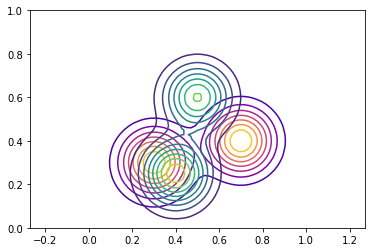

In [15]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,2
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
pi1 = np.array([[0.45,0.55]])
mu1 = np.array([[0.5,0.6],[0.4,0.25]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   

### Interpolation for $GW_2$ 
We compute the K0xK1 cost matrix between the Gaussian members of the mixtures.

In [16]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar

array([[0.  , 0.5 ],
       [0.45, 0.05]])

Now we can compute and display the barycenters between $\mu_0$ and $\mu_1$.

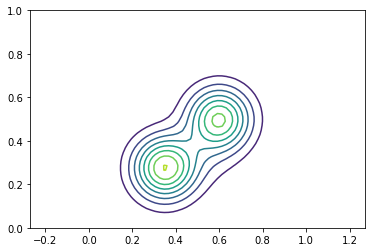

In [17]:
def barygmmot2d(t):
# Barycenters for GW2 in 2d
    pit = wstar.reshape(K0*K1,1).T
    mut = np.zeros((K0*K1,2))
    St  = np.zeros((K0*K1,2,2))
    for k in range(K0):
        for l in range(K1):
            mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
            Sigma1demi = spl.sqrtm(S1[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)
    
    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,8)
    plt.axis('equal')

    
barygmmot2d(0.5)

In [18]:
# interactive display    
interact(barygmmot2d,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot2d(t)>

### Interpolation for $W_2$

In the following we display the same barycenters but this time for the $W_2$ distance. The computation between two steps is not instantaneous and can take a few seconds.

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:1533: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


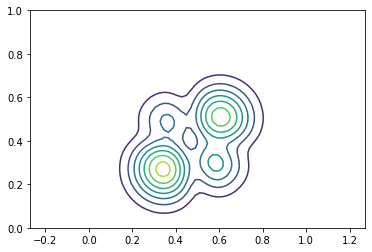

In [19]:
M = ot.dist(XX.reshape((n**2, 2)), XX.reshape((n**2, 2)))
gmm0 = densite_theorique2d(mu0,S0,pi0,XX)
gmm1 = densite_theorique2d(mu1,S1,pi1,XX)
A = []
A.append(gmm0)
A.append(gmm1)
A = np.array(A).T

def baryot(t):
    # Barycenters for W2 in 2d
    weights = np.array([1 - t, t])
    reg = 1e-3
    ott = ot.bregman.barycenter(A, M, reg, weights)
     # contour plot
    Z = ott.reshape(X.shape)
    CS = plt.contour(X, Y, Z, 8)
    plt.axis('equal')


baryot(0.5)

In [20]:
# interactive display    
interact(baryot,t=(0.05,0.96,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=0.96, min=0.05, step=0.05), Output()), _dom_…

<function __main__.baryot(t)>